In [2]:
import os, shutil
from keras import models
from keras import layers
from keras import losses
from keras import Input
from keras import Model
from keras import backend as K

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sp
from scipy.stats import kde
import importlib as im
import cnn_utilities as cn

Using TensorFlow backend.


In [3]:
full_data = pd.read_csv("../data_files/extant_training_set_0to40.cblv.csv", 
                   header =None, error_bad_lines = False, index_col = 0).to_numpy()

full_labels = pd.read_csv("../data_files/extant_training_set_0to40_labels.csv",
                    header = None, error_bad_lines = False).to_numpy()



In [4]:
# log R0 sample rate and migration rate
full_labels[:,5:8] = np.log(full_labels[:,5:8])

In [5]:
# randomize data order
randomized_idx = np.random.permutation(full_data.shape[0])
full_data = full_data[randomized_idx,:]
full_labels = full_labels[randomized_idx,:]

In [6]:
# setting up the data shape params and aux params
num_locs = 5
max_tips = 502
num_test = 1000 
num_validation = 5000  # found early stoping epoch number using 10000 validation
num_sample = full_data.shape[0]

num_tips = cn.get_num_tips(full_data)
subsample_prop = full_data[:,(max_tips-1) * 7]
mu = full_data[:,(max_tips - 3) * 7]


In [7]:
# normalize labels
labels = full_labels[0:num_sample,5:8]
norm_train_labels, train_label_means, train_label_sd = cn.normalize(labels[(num_test + num_validation):,:])
norm_validation_labels = cn.normalize(labels[num_test:num_test + num_validation,], (train_label_means, train_label_sd))
norm_test_labels = cn.normalize(labels[:num_test,], (train_label_means, train_label_sd))


In [8]:
# set up auxilliary priors and normalize; tree statistics and prior known parameter values (or ranges) 
# get num_tips and normalize
aux_priors_treestats = np.vstack((mu, subsample_prop, num_tips, 
                                  full_labels[0:num_sample,8], 
                                  full_labels[0:num_sample,9])).transpose()
norm_train_aux_priors_treestats, train_aux_priors_means, train_aux_priors_sd = cn.normalize(aux_priors_treestats[num_test + num_validation:,:])

norm_val_aux_priors_treestats = cn.normalize(aux_priors_treestats[num_test:num_test + num_validation,], 
                                            (train_aux_priors_means, train_aux_priors_sd))
norm_test_aux_priors_treestats = cn.normalize(aux_priors_treestats[:num_test,], 
                                            (train_aux_priors_means, train_aux_priors_sd))

norm_aux_priors_treestats = np.concatenate((norm_test_aux_priors_treestats, 
                                            norm_val_aux_priors_treestats, 
                                            norm_train_aux_priors_treestats))


In [9]:
# dev create data tensors
        
full_treeLocation_tensor, full_prior_tensor = cn.create_data_tensors(data = full_data[0:num_sample,:], 
                                                                        mu = norm_aux_priors_treestats[:,0],
                                                                        subsample_prop = norm_aux_priors_treestats[:,1],
                                                                        num_tips = norm_aux_priors_treestats[:,2],
                                                                        tmrca = norm_aux_priors_treestats[:,3],
                                                                        mean_bl = norm_aux_priors_treestats[:,4],
                                                                        num_locs = num_locs,
                                                                        max_tips = max_tips,
                                                                        cblv_contains_mu_rho = True)

train_treeLocation_tensor, validation_treeLocation_tensor,  test_treeLocation_tensor = cn.create_train_val_test_tensors(full_treeLocation_tensor, 
                                                                                                                        num_validation, num_test)
train_prior_tensor, validation_prior_tensor,  test_prior_tensor = cn.create_train_val_test_tensors(full_prior_tensor, 
                                                                                                   num_validation, num_test)

print(train_treeLocation_tensor.shape, train_prior_tensor.shape)
print(validation_treeLocation_tensor.shape, validation_prior_tensor.shape)
print(test_treeLocation_tensor.shape, test_prior_tensor.shape)


(105157, 499, 7) (105157, 5, 2)
(5000, 499, 7) (5000, 5, 2)
(1000, 499, 7) (1000, 5, 2)


In [10]:
## define pinball loss functions
def pinball_loss(y_true, y_pred, tau):
    err = y_true - y_pred
    return K.mean(K.maximum(tau*err, (tau-1)*err), axis=-1)

def pinball_loss_lower(y_true, y_pred):
    return pinball_loss(y_true, y_pred, tau = (1-qq)/2)

def pinball_loss_upper(y_true, y_pred):
    return pinball_loss(y_true, y_pred, tau = 1 - (1-qq)/2)

In [11]:
def create_model():
    input_treeLocation_tensor = Input(shape = train_treeLocation_tensor.shape[1:3])
    w1 = layers.Conv1D(64, 3, strides = 1, activation = 'relu', padding = 'same')(input_treeLocation_tensor)
    w = layers.Conv1D(64, 5, activation = 'relu', padding = 'same')(w1)
    #w = layers.MaxPooling1D(pool_size = 3, stride = 1)(w)
    w = layers.Conv1D(96, 5, activation = 'relu', padding = 'same')(w)
    w = layers.Conv1D(128, 5, activation = 'relu', padding = 'same')(w)
    w = layers.Conv1D(256, 7, activation = 'relu', padding = 'same')(w)
    w_global_avg = layers.GlobalAveragePooling1D(name = 'w')(w)

    w_stride = layers.Conv1D(64, 7, strides = 3, activation = 'relu', padding = 'same')(w1)
    w_stride = layers.Conv1D(96, 9, strides = 6, activation = 'relu', padding = 'same')(w_stride)
    w_stride_global_avg = layers.GlobalAveragePooling1D(name = 'w_stride_global_avg')(w_stride)

    # tree + geolocation dilated
    w_dilated = layers.Conv1D(32, 3, dilation_rate = 2, activation = 'relu', padding = "same")(w1)
    w_dilated = layers.Conv1D(64, 5, dilation_rate = 4, activation = 'relu', padding = "same")(w_dilated)
    w_dilated = layers.Conv1D(128, 7, dilation_rate = 8, activation = 'relu', padding = "same")(w_dilated)
    w_dilated_global_avg = layers.GlobalAveragePooling1D(name = 'w_dilated_global_avg')(w_dilated)

    # prior known parameters and data statistics
    input_priors_tensor = Input(shape = train_prior_tensor.shape[1:3])
    priors = layers.Flatten()(input_priors_tensor)
    priors = layers.Dense(32, activation = 'relu', kernel_initializer = 'VarianceScaling', name = 'prior1')(priors)

    # concatenate all above -> deep fully connected network
    concatenated_wxyz = layers.Concatenate(axis = 1, name = 'all_concatenated')([w_stride_global_avg,
                                                                                 w_global_avg,
                                                                                 w_dilated_global_avg,
                                                                                 priors])

    wxyz = layers.Dense(256, activation = 'relu', kernel_initializer = 'VarianceScaling')(concatenated_wxyz)
    wxyz = layers.Dense(128, activation = 'relu', kernel_initializer = 'VarianceScaling')(wxyz)
    wxyz = layers.Dense(64, activation = 'relu', kernel_initializer = 'VarianceScaling')(wxyz)
    wxyz = layers.Dense(32, activation = 'relu', kernel_initializer = 'VarianceScaling')(wxyz)

    lower_output_R0_sampleRate_migrationRate = layers.Dense(3, name = "lower_output_R0_sampleRate_migrationRate")(wxyz)
    upper_output_R0_sampleRate_migrationRate = layers.Dense(3, name = "upper_output_R0_sampleRate_migrationRate")(wxyz)
    
    return Model(inputs = [input_treeLocation_tensor, input_priors_tensor], 
                outputs = [lower_output_R0_sampleRate_migrationRate, upper_output_R0_sampleRate_migrationRate])
 

Train on 105157 samples, validate on 5000 samples
Epoch 1/15
105157/105157 [==============================] - 236s 2ms/step - loss: 0.0767 - lower_output_R0_sampleRate_migrationRate_loss: 0.0488 - upper_output_R0_sampleRate_migrationRate_loss: 0.0278 - lower_output_R0_sampleRate_migrationRate_mae: 1.5143 - lower_output_R0_sampleRate_migrationRate_acc: 0.5424 - lower_output_R0_sampleRate_migrationRate_mape: 843.2227 - upper_output_R0_sampleRate_migrationRate_mae: 0.9469 - upper_output_R0_sampleRate_migrationRate_acc: 0.5842 - upper_output_R0_sampleRate_migrationRate_mape: 558.2675 - val_loss: 0.0533 - val_lower_output_R0_sampleRate_migrationRate_loss: 0.0317 - val_upper_output_R0_sampleRate_migrationRate_loss: 0.0216 - val_lower_output_R0_sampleRate_migrationRate_mae: 1.1845 - val_lower_output_R0_sampleRate_migrationRate_acc: 0.6490 - val_lower_output_R0_sampleRate_migrationRate_mape: 657.8272 - val_upper_output_R0_sampleRate_migrationRate_mae: 0.7663 - val_upper_output_R0_sampleRate_mi

Epoch 9/15
105157/105157 [==============================] - 239s 2ms/step - loss: 0.0302 - lower_output_R0_sampleRate_migrationRate_loss: 0.0166 - upper_output_R0_sampleRate_migrationRate_loss: 0.0136 - lower_output_R0_sampleRate_migrationRate_mae: 0.5583 - lower_output_R0_sampleRate_migrationRate_acc: 0.8294 - lower_output_R0_sampleRate_migrationRate_mape: 308.9898 - upper_output_R0_sampleRate_migrationRate_mae: 0.4794 - upper_output_R0_sampleRate_migrationRate_acc: 0.8206 - upper_output_R0_sampleRate_migrationRate_mape: 307.1264 - val_loss: 0.0303 - val_lower_output_R0_sampleRate_migrationRate_loss: 0.0163 - val_upper_output_R0_sampleRate_migrationRate_loss: 0.0138 - val_lower_output_R0_sampleRate_migrationRate_mae: 0.5673 - val_lower_output_R0_sampleRate_migrationRate_acc: 0.8422 - val_lower_output_R0_sampleRate_migrationRate_mape: 314.9361 - val_upper_output_R0_sampleRate_migrationRate_mae: 0.4486 - val_upper_output_R0_sampleRate_migrationRate_acc: 0.8324 - val_upper_output_R0_samp

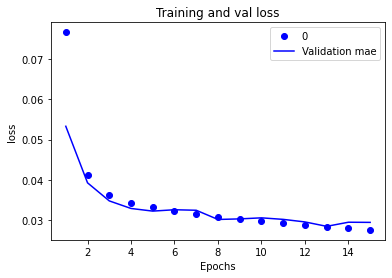

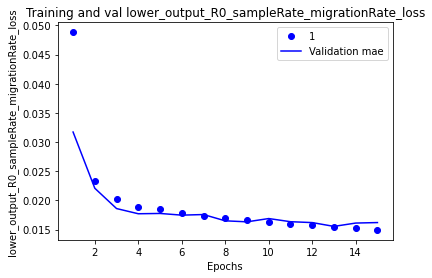

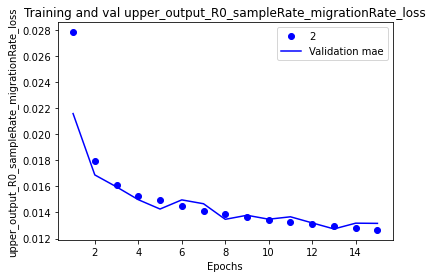

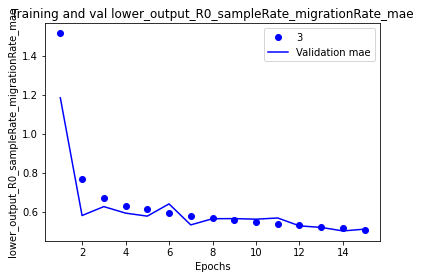

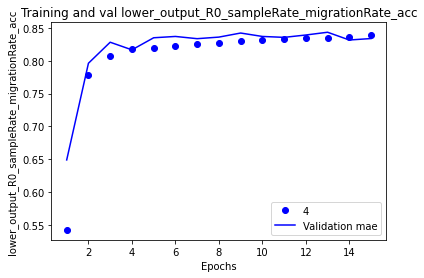

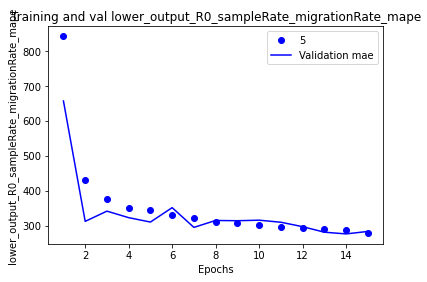

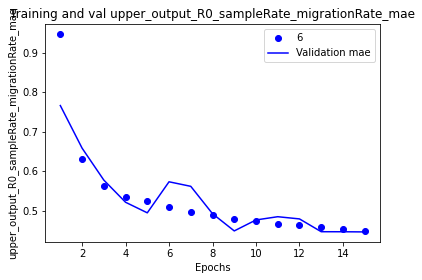

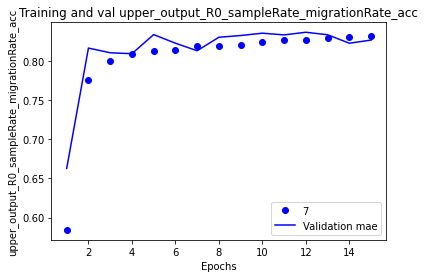

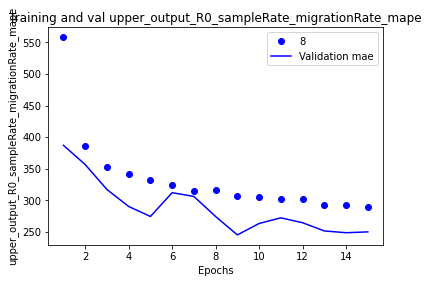

In [12]:
# instantiate MODEL
# set inner quantile
qq = 0.95

mymodel_95q = create_model()
mymodel_95q.compile(optimizer = 'adam', 
                loss = [pinball_loss_lower, pinball_loss_upper], 
                metrics = ['mae', 'acc', 'mape'])

history = mymodel_95q.fit([train_treeLocation_tensor, train_prior_tensor], 
                      [norm_train_labels, norm_train_labels],
                    epochs = 15, batch_size = 128, 
                    validation_data = ([validation_treeLocation_tensor, validation_prior_tensor], 
                                       [norm_validation_labels, norm_validation_labels]))



# make history plots
cn.make_history_plot(history)


In [70]:
# ## checking
# qq=0.5
# check_model = models.load_model("trained_quantile_CNN/cqr50_train_extant_R0_sampleRate_migrationRate.hdf5",
#                                custom_objects = {'pinball_loss_lower': pinball_loss_lower, 
#                                                 'pinball_loss_upper': pinball_loss_upper})

# mean_sd = pd.read_csv("trained_quantile_CNN/cqr_train_extant_normalization_label_mean_sd.csv", 
#                      index_col = 0).to_numpy()

# train_means = mean_sd[0,:]
# train_sd = mean_sd[1,:]
# train_aux_priors_means = train_means[3:,]
# train_aux_priors_sd = train_sd[3:,]

# num_locs = 5
# max_tips = 502


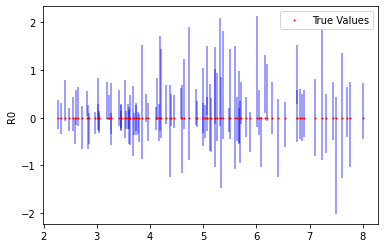

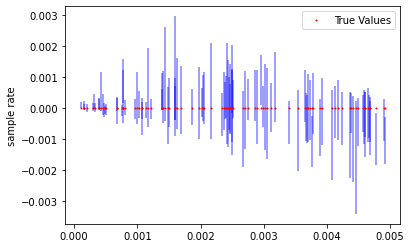

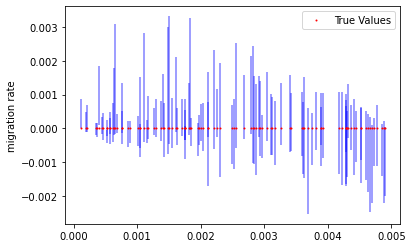

In [13]:
# test data plots

normalized_test_preds_low, normalized_test_preds_up = mymodel_95q.predict([test_treeLocation_tensor[0:100,:,:], 
                                          test_prior_tensor[0:100,:,:]])

# reverse normalization
denormalized_test_labels = cn.denormalize(norm_test_labels[0:100,:], train_label_means, train_label_sd)
denormalized_test_labels = np.exp(denormalized_test_labels)

test_preds_low = cn.denormalize(normalized_test_preds_low, train_label_means, train_label_sd)
test_preds_low = np.exp(test_preds_low)
test_preds_up = cn.denormalize(normalized_test_preds_up, train_label_means, train_label_sd)
test_preds_up = np.exp(test_preds_up)

# make scatter plots
cn.plot_QI(test_preds_low, test_preds_up, denormalized_test_labels, 
                     param_names = ["R0", "sample rate", "migration rate"])


In [14]:
# SAVE MODEL to FILE
import csv

# save normalization coefs
all_means = np.append(train_label_means, train_aux_priors_means)
all_sd = np.append(train_label_sd, train_aux_priors_sd)
with open('trained_quantile_CNN/cqr_train_extant_normalization_label_mean_sd.csv', 'w') as file:
    the_writer = csv.writer(file)
    the_writer.writerow(["mean_sd","R0","log_sample_rate", "log_migration_rate", 
                                "mu", "subsample_proportion", "num_tips",
                                "tmrca", "mean_bl"])
    
    the_writer.writerow(np.append("mean", all_means))
    the_writer.writerow(np.append("sd", all_sd))


# store model
mymodel_95q.save("trained_quantile_CNN/cqr95_train_extant_R0_sampleRate_migrationRate.hdf5")


Train on 105157 samples, validate on 5000 samples
Epoch 1/15
105157/105157 [==============================] - 228s 2ms/step - loss: 0.1167 - lower_output_R0_sampleRate_migrationRate_loss: 0.0706 - upper_output_R0_sampleRate_migrationRate_loss: 0.0461 - lower_output_R0_sampleRate_migrationRate_mae: 1.0389 - lower_output_R0_sampleRate_migrationRate_acc: 0.6289 - lower_output_R0_sampleRate_migrationRate_mape: 562.3669 - upper_output_R0_sampleRate_migrationRate_mae: 0.7656 - upper_output_R0_sampleRate_migrationRate_acc: 0.6500 - upper_output_R0_sampleRate_migrationRate_mape: 441.0779 - val_loss: 0.0690 - val_lower_output_R0_sampleRate_migrationRate_loss: 0.0372 - val_upper_output_R0_sampleRate_migrationRate_loss: 0.0316 - val_lower_output_R0_sampleRate_migrationRate_mae: 0.6215 - val_lower_output_R0_sampleRate_migrationRate_acc: 0.8068 - val_lower_output_R0_sampleRate_migrationRate_mape: 343.4182 - val_upper_output_R0_sampleRate_migrationRate_mae: 0.5421 - val_upper_output_R0_sampleRate_mi

Epoch 9/15
105157/105157 [==============================] - 230s 2ms/step - loss: 0.0538 - lower_output_R0_sampleRate_migrationRate_loss: 0.0291 - upper_output_R0_sampleRate_migrationRate_loss: 0.0247 - lower_output_R0_sampleRate_migrationRate_mae: 0.4725 - lower_output_R0_sampleRate_migrationRate_acc: 0.8320 - lower_output_R0_sampleRate_migrationRate_mape: 262.9595 - upper_output_R0_sampleRate_migrationRate_mae: 0.4213 - upper_output_R0_sampleRate_migrationRate_acc: 0.8284 - upper_output_R0_sampleRate_migrationRate_mape: 267.8080 - val_loss: 0.0621 - val_lower_output_R0_sampleRate_migrationRate_loss: 0.0336 - val_upper_output_R0_sampleRate_migrationRate_loss: 0.0279 - val_lower_output_R0_sampleRate_migrationRate_mae: 0.5204 - val_lower_output_R0_sampleRate_migrationRate_acc: 0.8084 - val_lower_output_R0_sampleRate_migrationRate_mape: 283.8896 - val_upper_output_R0_sampleRate_migrationRate_mae: 0.4559 - val_upper_output_R0_sampleRate_migrationRate_acc: 0.8104 - val_upper_output_R0_samp

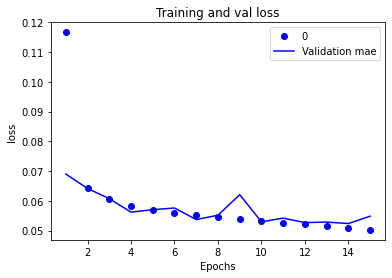

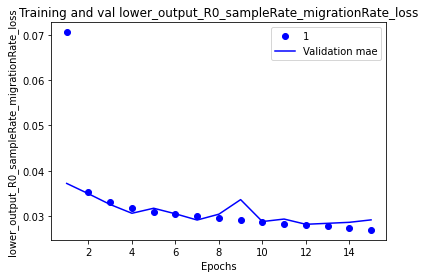

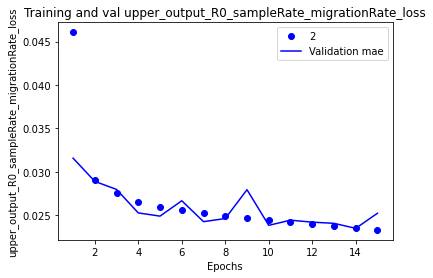

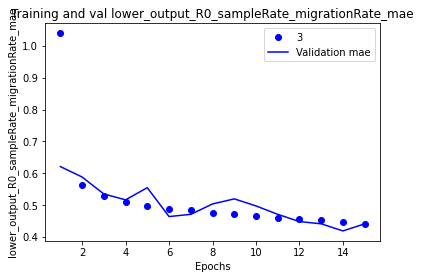

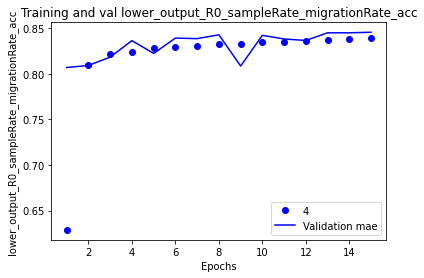

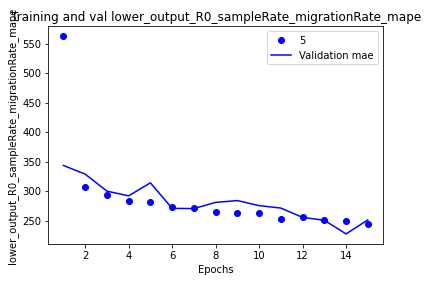

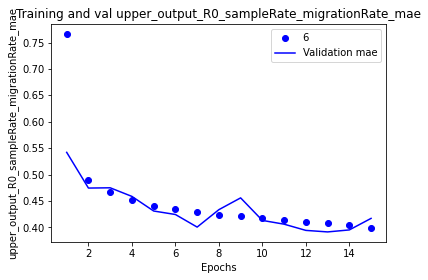

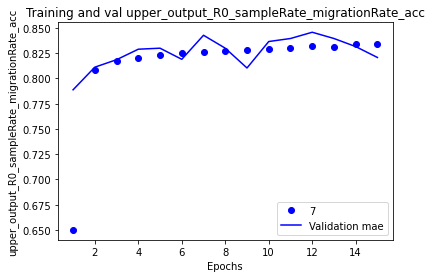

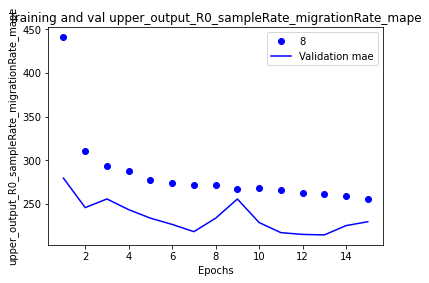

In [15]:
# instantiate MODEL
# set inner quantile
qq = 0.90

def pinball_loss_lower(y_true, y_pred):
    return pinball_loss(y_true, y_pred, tau = (1-qq)/2)

def pinball_loss_upper(y_true, y_pred):
    return pinball_loss(y_true, y_pred, tau = 1 - (1-qq)/2)

mymodel_90q = create_model()
mymodel_90q.compile(optimizer = 'adam', 
                loss = [pinball_loss_lower, pinball_loss_upper], 
                metrics = ['mae', 'acc', 'mape'])

history = mymodel_90q.fit([train_treeLocation_tensor, train_prior_tensor], 
                      [norm_train_labels, norm_train_labels],
                    epochs = 15, batch_size = 128, 
                    validation_data = ([validation_treeLocation_tensor, validation_prior_tensor], 
                                       [norm_validation_labels, norm_validation_labels]))



# make history plots
cn.make_history_plot(history)

# store model
mymodel_90q.save("trained_quantile_CNN/cqr90_train_extant_R0_sampleRate_migrationRate.hdf5")


Train on 105157 samples, validate on 5000 samples
Epoch 1/15
105157/105157 [==============================] - 228s 2ms/step - loss: 0.2072 - lower_output_R0_sampleRate_migrationRate_loss: 0.1216 - upper_output_R0_sampleRate_migrationRate_loss: 0.0856 - lower_output_R0_sampleRate_migrationRate_mae: 0.6840 - lower_output_R0_sampleRate_migrationRate_acc: 0.6695 - lower_output_R0_sampleRate_migrationRate_mape: 359.0276 - upper_output_R0_sampleRate_migrationRate_mae: 0.5699 - upper_output_R0_sampleRate_migrationRate_acc: 0.6857 - upper_output_R0_sampleRate_migrationRate_mape: 330.0369 - val_loss: 0.1281 - val_lower_output_R0_sampleRate_migrationRate_loss: 0.0695 - val_upper_output_R0_sampleRate_migrationRate_loss: 0.0578 - val_lower_output_R0_sampleRate_migrationRate_mae: 0.4498 - val_lower_output_R0_sampleRate_migrationRate_acc: 0.8102 - val_lower_output_R0_sampleRate_migrationRate_mape: 242.8790 - val_upper_output_R0_sampleRate_migrationRate_mae: 0.3720 - val_upper_output_R0_sampleRate_mi

Epoch 9/15
105157/105157 [==============================] - 229s 2ms/step - loss: 0.0987 - lower_output_R0_sampleRate_migrationRate_loss: 0.0521 - upper_output_R0_sampleRate_migrationRate_loss: 0.0467 - lower_output_R0_sampleRate_migrationRate_mae: 0.3163 - lower_output_R0_sampleRate_migrationRate_acc: 0.8500 - lower_output_R0_sampleRate_migrationRate_mape: 168.6763 - upper_output_R0_sampleRate_migrationRate_mae: 0.3008 - upper_output_R0_sampleRate_migrationRate_acc: 0.8484 - upper_output_R0_sampleRate_migrationRate_mape: 196.3441 - val_loss: 0.0994 - val_lower_output_R0_sampleRate_migrationRate_loss: 0.0517 - val_upper_output_R0_sampleRate_migrationRate_loss: 0.0470 - val_lower_output_R0_sampleRate_migrationRate_mae: 0.3130 - val_lower_output_R0_sampleRate_migrationRate_acc: 0.8534 - val_lower_output_R0_sampleRate_migrationRate_mape: 180.5522 - val_upper_output_R0_sampleRate_migrationRate_mae: 0.3023 - val_upper_output_R0_sampleRate_migrationRate_acc: 0.8546 - val_upper_output_R0_samp

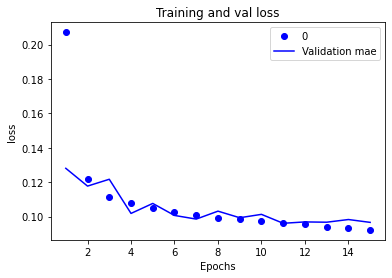

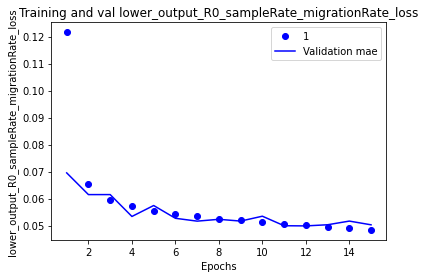

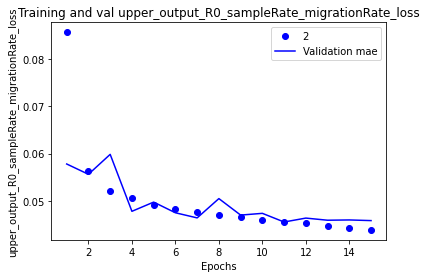

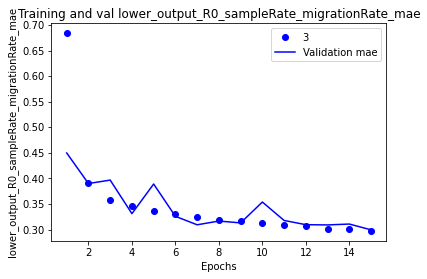

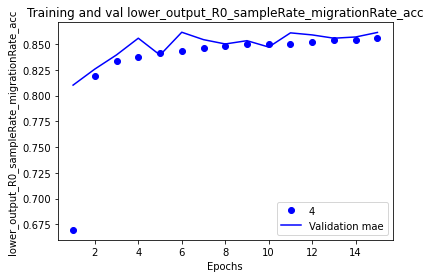

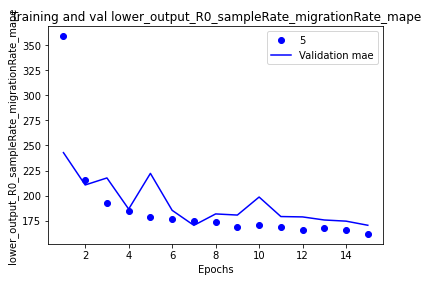

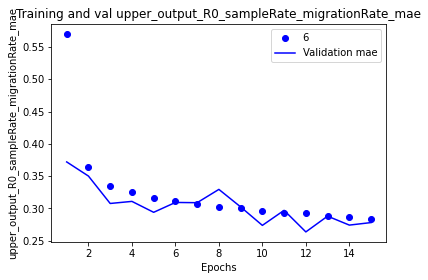

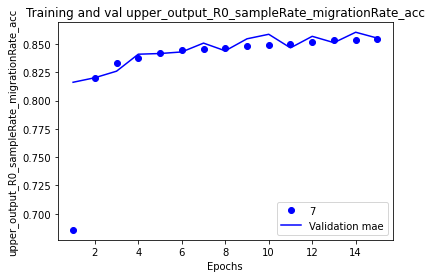

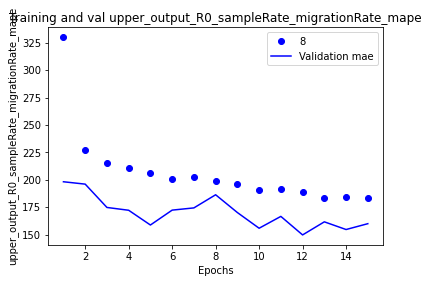

In [16]:
# instantiate MODEL
# set inner quantile
qq = 0.75

def pinball_loss_lower(y_true, y_pred):
    return pinball_loss(y_true, y_pred, tau = (1-qq)/2)

def pinball_loss_upper(y_true, y_pred):
    return pinball_loss(y_true, y_pred, tau = 1 - (1-qq)/2)

mymodel_75q = create_model()
mymodel_75q.compile(optimizer = 'adam', 
                loss = [pinball_loss_lower, pinball_loss_upper], 
                metrics = ['mae', 'acc', 'mape'])

history = mymodel_75q.fit([train_treeLocation_tensor, train_prior_tensor], 
                      [norm_train_labels, norm_train_labels],
                    epochs = 15, batch_size = 128, 
                    validation_data = ([validation_treeLocation_tensor, validation_prior_tensor], 
                                       [norm_validation_labels, norm_validation_labels]))



# make history plots
cn.make_history_plot(history)

# store model
mymodel_75q.save("trained_quantile_CNN/cqr75_train_extant_R0_sampleRate_migrationRate.hdf5")


Train on 105157 samples, validate on 5000 samples
Epoch 1/15
105157/105157 [==============================] - 228s 2ms/step - loss: 0.3473 - lower_output_R0_sampleRate_migrationRate_loss: 0.1969 - upper_output_R0_sampleRate_migrationRate_loss: 0.1504 - lower_output_R0_sampleRate_migrationRate_mae: 0.5456 - lower_output_R0_sampleRate_migrationRate_acc: 0.6542 - lower_output_R0_sampleRate_migrationRate_mape: 249.6326 - upper_output_R0_sampleRate_migrationRate_mae: 0.5071 - upper_output_R0_sampleRate_migrationRate_acc: 0.6629 - upper_output_R0_sampleRate_migrationRate_mape: 282.1480 - val_loss: 0.3102 - val_lower_output_R0_sampleRate_migrationRate_loss: 0.1773 - val_upper_output_R0_sampleRate_migrationRate_loss: 0.1333 - val_lower_output_R0_sampleRate_migrationRate_mae: 0.5033 - val_lower_output_R0_sampleRate_migrationRate_acc: 0.6786 - val_lower_output_R0_sampleRate_migrationRate_mape: 214.6867 - val_upper_output_R0_sampleRate_migrationRate_mae: 0.4544 - val_upper_output_R0_sampleRate_mi

Epoch 9/15
105157/105157 [==============================] - 230s 2ms/step - loss: 0.2881 - lower_output_R0_sampleRate_migrationRate_loss: 0.1657 - upper_output_R0_sampleRate_migrationRate_loss: 0.1223 - lower_output_R0_sampleRate_migrationRate_mae: 0.4580 - lower_output_R0_sampleRate_migrationRate_acc: 0.6839 - lower_output_R0_sampleRate_migrationRate_mape: 182.4258 - upper_output_R0_sampleRate_migrationRate_mae: 0.4214 - upper_output_R0_sampleRate_migrationRate_acc: 0.6934 - upper_output_R0_sampleRate_migrationRate_mape: 223.9204 - val_loss: 0.2844 - val_lower_output_R0_sampleRate_migrationRate_loss: 0.1638 - val_upper_output_R0_sampleRate_migrationRate_loss: 0.1212 - val_lower_output_R0_sampleRate_migrationRate_mae: 0.4708 - val_lower_output_R0_sampleRate_migrationRate_acc: 0.6900 - val_lower_output_R0_sampleRate_migrationRate_mape: 200.4947 - val_upper_output_R0_sampleRate_migrationRate_mae: 0.4027 - val_upper_output_R0_sampleRate_migrationRate_acc: 0.7028 - val_upper_output_R0_samp

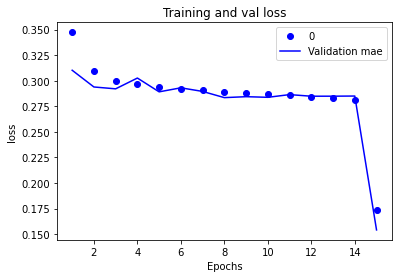

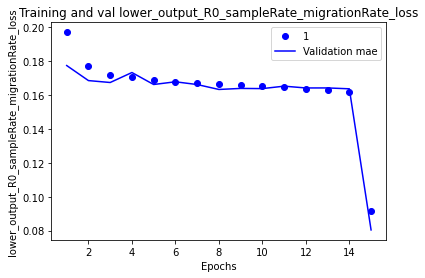

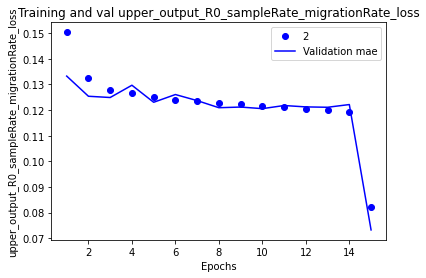

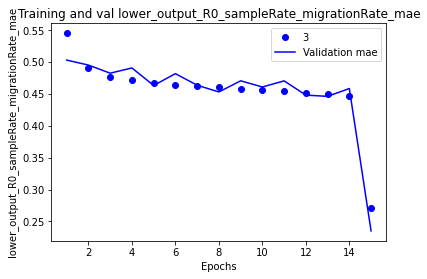

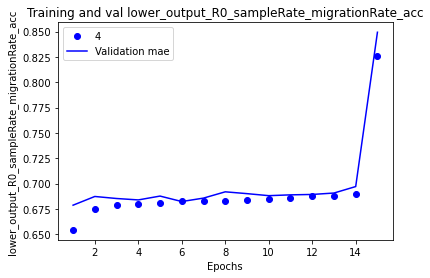

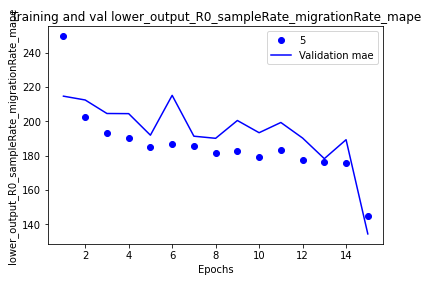

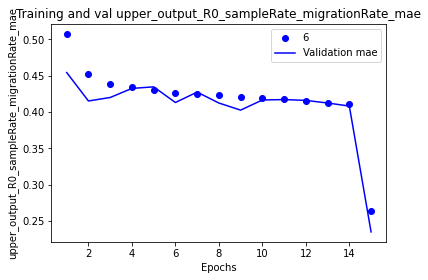

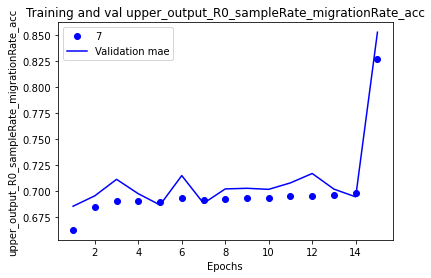

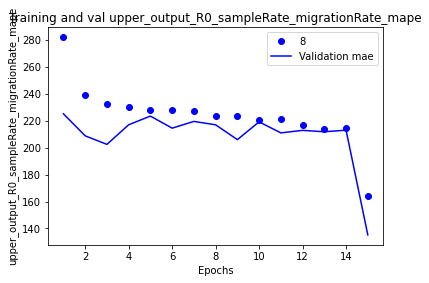

In [17]:
# instantiate MODEL
# set inner quantile
qq = 0.50

def pinball_loss_lower(y_true, y_pred):
    return pinball_loss(y_true, y_pred, tau = (1-qq)/2)

def pinball_loss_upper(y_true, y_pred):
    return pinball_loss(y_true, y_pred, tau = 1 - (1-qq)/2)

mymodel_50q = create_model()
mymodel_50q.compile(optimizer = 'adam', 
                loss = [pinball_loss_lower, pinball_loss_upper], 
                metrics = ['mae', 'acc', 'mape'])

history = mymodel_50q.fit([train_treeLocation_tensor, train_prior_tensor], 
                      [norm_train_labels, norm_train_labels],
                    epochs = 15, batch_size = 128, 
                    validation_data = ([validation_treeLocation_tensor, validation_prior_tensor], 
                                       [norm_validation_labels, norm_validation_labels]))



# make history plots
cn.make_history_plot(history)

# store model
mymodel_50q.save("trained_quantile_CNN/cqr50_train_extant_R0_sampleRate_migrationRate.hdf5")


Train on 105157 samples, validate on 5000 samples
Epoch 1/15
105157/105157 [==============================] - 217s 2ms/step - loss: 0.4179 - lower_output_R0_sampleRate_migrationRate_loss: 0.2227 - upper_output_R0_sampleRate_migrationRate_loss: 0.1952 - lower_output_R0_sampleRate_migrationRate_mae: 0.4625 - lower_output_R0_sampleRate_migrationRate_acc: 0.6700 - lower_output_R0_sampleRate_migrationRate_mape: 427.6680 - upper_output_R0_sampleRate_migrationRate_mae: 0.4561 - upper_output_R0_sampleRate_migrationRate_acc: 0.6735 - upper_output_R0_sampleRate_migrationRate_mape: 401.8466 - val_loss: 0.3767 - val_lower_output_R0_sampleRate_migrationRate_loss: 0.2002 - val_upper_output_R0_sampleRate_migrationRate_loss: 0.1771 - val_lower_output_R0_sampleRate_migrationRate_mae: 0.4119 - val_lower_output_R0_sampleRate_migrationRate_acc: 0.7000 - val_lower_output_R0_sampleRate_migrationRate_mape: 393.1757 - val_upper_output_R0_sampleRate_migrationRate_mae: 0.4109 - val_upper_output_R0_sampleRate_mi

Epoch 9/15
105157/105157 [==============================] - 236s 2ms/step - loss: 0.1808 - lower_output_R0_sampleRate_migrationRate_loss: 0.0918 - upper_output_R0_sampleRate_migrationRate_loss: 0.0890 - lower_output_R0_sampleRate_migrationRate_mae: 0.1998 - lower_output_R0_sampleRate_migrationRate_acc: 0.8510 - lower_output_R0_sampleRate_migrationRate_mape: 212.8835 - upper_output_R0_sampleRate_migrationRate_mae: 0.1995 - upper_output_R0_sampleRate_migrationRate_acc: 0.8507 - upper_output_R0_sampleRate_migrationRate_mape: 154.0981 - val_loss: 0.1865 - val_lower_output_R0_sampleRate_migrationRate_loss: 0.0950 - val_upper_output_R0_sampleRate_migrationRate_loss: 0.0937 - val_lower_output_R0_sampleRate_migrationRate_mae: 0.2143 - val_lower_output_R0_sampleRate_migrationRate_acc: 0.8514 - val_lower_output_R0_sampleRate_migrationRate_mape: 145.9550 - val_upper_output_R0_sampleRate_migrationRate_mae: 0.1958 - val_upper_output_R0_sampleRate_migrationRate_acc: 0.8564 - val_upper_output_R0_samp

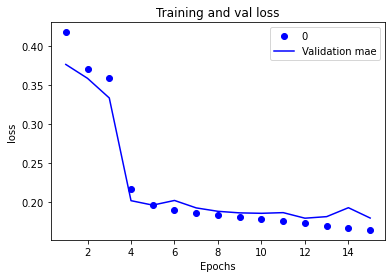

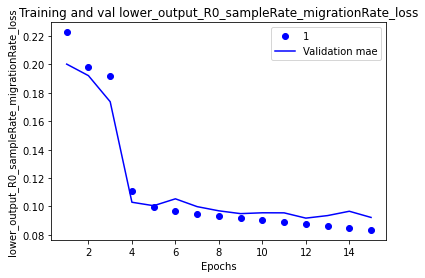

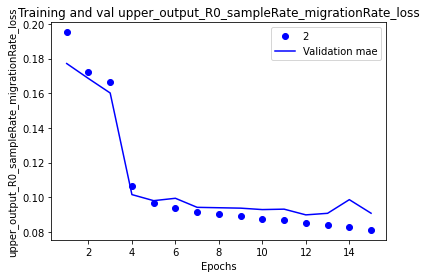

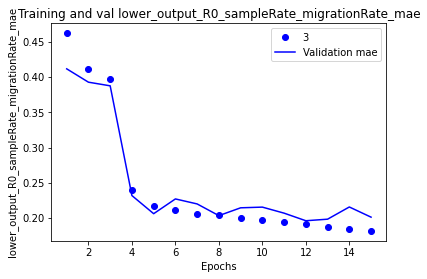

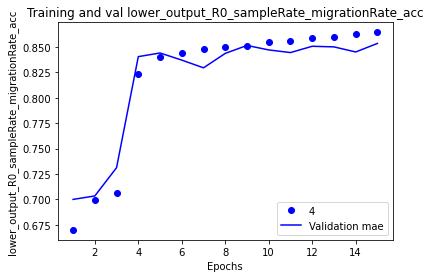

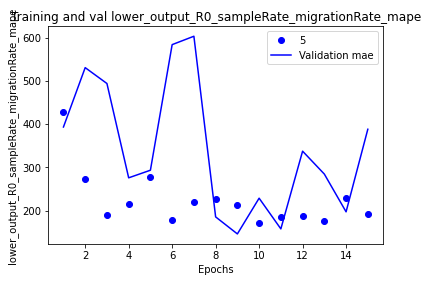

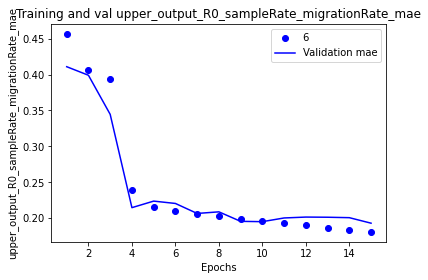

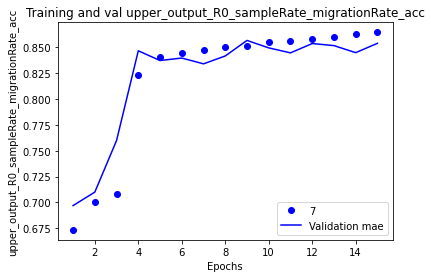

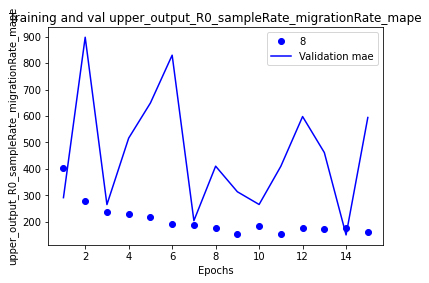

In [65]:
# instantiate MODEL
# set inner quantile
qq = 0.25

def pinball_loss_lower(y_true, y_pred):
    return pinball_loss(y_true, y_pred, tau = (1-qq)/2)

def pinball_loss_upper(y_true, y_pred):
    return pinball_loss(y_true, y_pred, tau = 1 - (1-qq)/2)

# mymodel_25q = Model(inputs = [input_treeLocation_tensor, input_priors_tensor], 
#                 outputs = [lower_output_R0_sampleRate_migrationRate, upper_output_R0_sampleRate_migrationRate])

mymodel_25q = create_model()
mymodel_25q.compile(optimizer = 'adam', 
                loss = [pinball_loss_lower, pinball_loss_upper], 
                metrics = ['mae', 'acc', 'mape'])

history = mymodel_25q.fit([train_treeLocation_tensor, train_prior_tensor], 
                      [norm_train_labels, norm_train_labels],
                    epochs = 15, batch_size = 128, 
                    validation_data = ([validation_treeLocation_tensor, validation_prior_tensor], 
                                       [norm_validation_labels, norm_validation_labels]))



# make history plots
cn.make_history_plot(history)

# store model
mymodel_25q.save("trained_quantile_CNN/cqr25_train_extant_R0_sampleRate_migrationRate.hdf5")


Train on 105157 samples, validate on 5000 samples
Epoch 1/15
105157/105157 [==============================] - 222s 2ms/step - loss: 0.4287 - lower_output_R0_sampleRate_migrationRate_loss: 0.2198 - upper_output_R0_sampleRate_migrationRate_loss: 0.2089 - lower_output_R0_sampleRate_migrationRate_mae: 0.4351 - lower_output_R0_sampleRate_migrationRate_acc: 0.6837 - lower_output_R0_sampleRate_migrationRate_mape: 485.4037 - upper_output_R0_sampleRate_migrationRate_mae: 0.4355 - upper_output_R0_sampleRate_migrationRate_acc: 0.6830 - upper_output_R0_sampleRate_migrationRate_mape: 494.1623 - val_loss: 0.4001 - val_lower_output_R0_sampleRate_migrationRate_loss: 0.2055 - val_upper_output_R0_sampleRate_migrationRate_loss: 0.1963 - val_lower_output_R0_sampleRate_migrationRate_mae: 0.4058 - val_lower_output_R0_sampleRate_migrationRate_acc: 0.6960 - val_lower_output_R0_sampleRate_migrationRate_mape: 477.9349 - val_upper_output_R0_sampleRate_migrationRate_mae: 0.4096 - val_upper_output_R0_sampleRate_mi

Epoch 9/15
105157/105157 [==============================] - 229s 2ms/step - loss: 0.1871 - lower_output_R0_sampleRate_migrationRate_loss: 0.0942 - upper_output_R0_sampleRate_migrationRate_loss: 0.0929 - lower_output_R0_sampleRate_migrationRate_mae: 0.1901 - lower_output_R0_sampleRate_migrationRate_acc: 0.8550 - lower_output_R0_sampleRate_migrationRate_mape: 186.7646 - upper_output_R0_sampleRate_migrationRate_mae: 0.1899 - upper_output_R0_sampleRate_migrationRate_acc: 0.8547 - upper_output_R0_sampleRate_migrationRate_mape: 184.2959 - val_loss: 0.1923 - val_lower_output_R0_sampleRate_migrationRate_loss: 0.0983 - val_upper_output_R0_sampleRate_migrationRate_loss: 0.0961 - val_lower_output_R0_sampleRate_migrationRate_mae: 0.2006 - val_lower_output_R0_sampleRate_migrationRate_acc: 0.8436 - val_lower_output_R0_sampleRate_migrationRate_mape: 197.5784 - val_upper_output_R0_sampleRate_migrationRate_mae: 0.1915 - val_upper_output_R0_sampleRate_migrationRate_acc: 0.8458 - val_upper_output_R0_samp

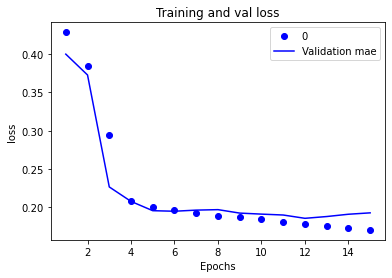

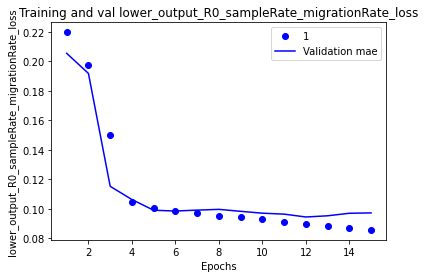

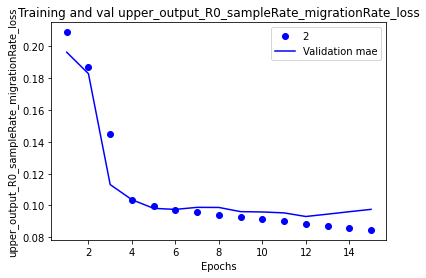

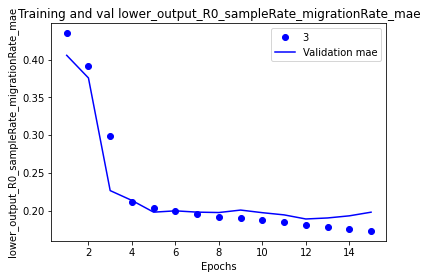

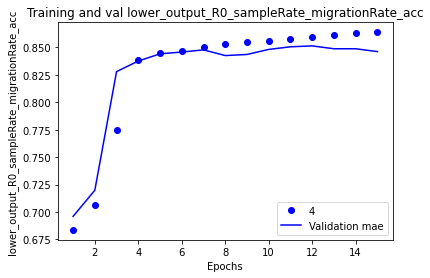

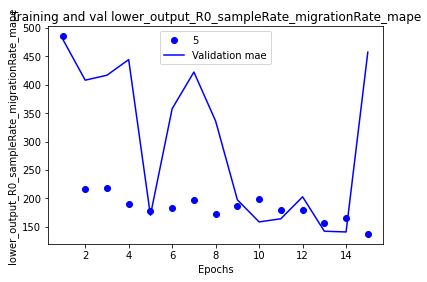

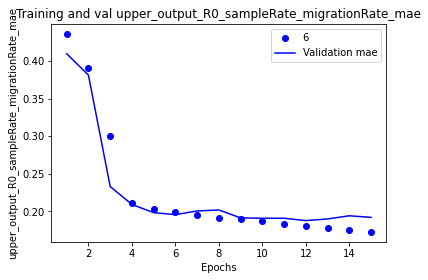

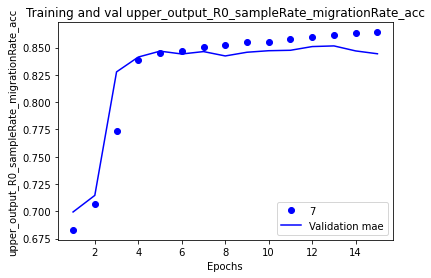

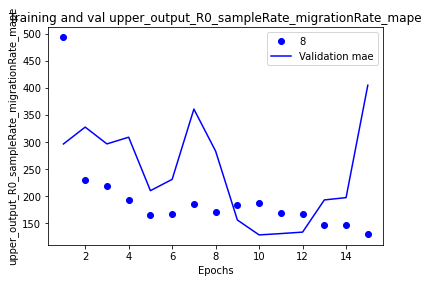

In [66]:
# instantiate MODEL
# set inner quantile
qq = 0.10

def pinball_loss_lower(y_true, y_pred):
    return pinball_loss(y_true, y_pred, tau = (1-qq)/2)

def pinball_loss_upper(y_true, y_pred):
    return pinball_loss(y_true, y_pred, tau = 1 - (1-qq)/2)

mymodel_10q = create_model()
mymodel_10q.compile(optimizer = 'adam', 
                loss = [pinball_loss_lower, pinball_loss_upper], 
                metrics = ['mae', 'acc', 'mape'])

history = mymodel_10q.fit([train_treeLocation_tensor, train_prior_tensor], 
                      [norm_train_labels, norm_train_labels],
                    epochs = 15, batch_size = 128, 
                    validation_data = ([validation_treeLocation_tensor, validation_prior_tensor], 
                                       [norm_validation_labels, norm_validation_labels]))



# make history plots
cn.make_history_plot(history)

# store model
mymodel_10q.save("trained_quantile_CNN/cqr10_train_extant_R0_sampleRate_migrationRate.hdf5")


Train on 105157 samples, validate on 5000 samples
Epoch 1/15
105157/105157 [==============================] - 221s 2ms/step - loss: 0.4288 - lower_output_R0_sampleRate_migrationRate_loss: 0.2174 - upper_output_R0_sampleRate_migrationRate_loss: 0.2114 - lower_output_R0_sampleRate_migrationRate_mae: 0.4309 - lower_output_R0_sampleRate_migrationRate_acc: 0.6812 - lower_output_R0_sampleRate_migrationRate_mape: 462.0280 - upper_output_R0_sampleRate_migrationRate_mae: 0.4300 - upper_output_R0_sampleRate_migrationRate_acc: 0.6863 - upper_output_R0_sampleRate_migrationRate_mape: 435.3593 - val_loss: 0.3781 - val_lower_output_R0_sampleRate_migrationRate_loss: 0.1918 - val_upper_output_R0_sampleRate_migrationRate_loss: 0.1876 - val_lower_output_R0_sampleRate_migrationRate_mae: 0.3783 - val_lower_output_R0_sampleRate_migrationRate_acc: 0.7244 - val_lower_output_R0_sampleRate_migrationRate_mape: 858.2030 - val_upper_output_R0_sampleRate_migrationRate_mae: 0.3810 - val_upper_output_R0_sampleRate_mi

Epoch 9/15
105157/105157 [==============================] - 220s 2ms/step - loss: 0.1885 - lower_output_R0_sampleRate_migrationRate_loss: 0.0945 - upper_output_R0_sampleRate_migrationRate_loss: 0.0940 - lower_output_R0_sampleRate_migrationRate_mae: 0.1892 - lower_output_R0_sampleRate_migrationRate_acc: 0.8537 - lower_output_R0_sampleRate_migrationRate_mape: 209.1644 - upper_output_R0_sampleRate_migrationRate_mae: 0.1892 - upper_output_R0_sampleRate_migrationRate_acc: 0.8537 - upper_output_R0_sampleRate_migrationRate_mape: 201.2280 - val_loss: 0.1928 - val_lower_output_R0_sampleRate_migrationRate_loss: 0.0979 - val_upper_output_R0_sampleRate_migrationRate_loss: 0.0982 - val_lower_output_R0_sampleRate_migrationRate_mae: 0.1945 - val_lower_output_R0_sampleRate_migrationRate_acc: 0.8534 - val_lower_output_R0_sampleRate_migrationRate_mape: 272.5411 - val_upper_output_R0_sampleRate_migrationRate_mae: 0.1923 - val_upper_output_R0_sampleRate_migrationRate_acc: 0.8496 - val_upper_output_R0_samp

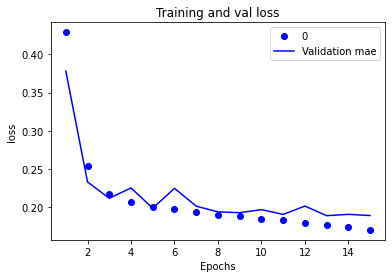

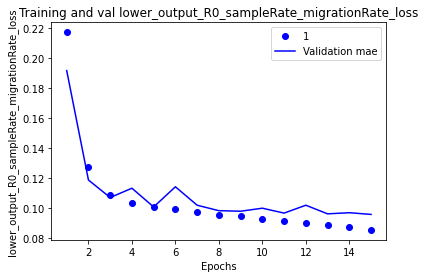

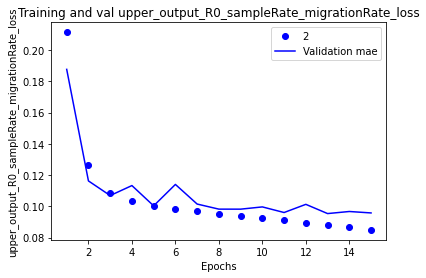

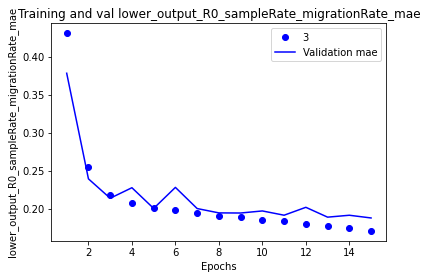

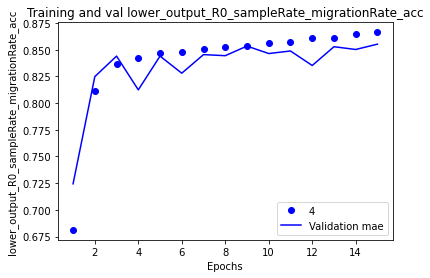

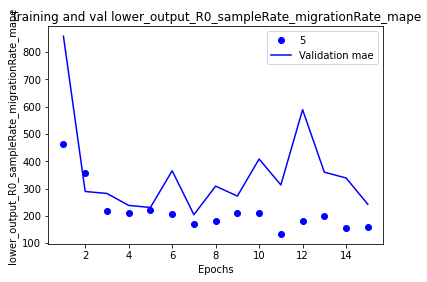

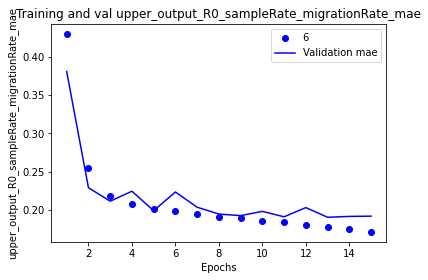

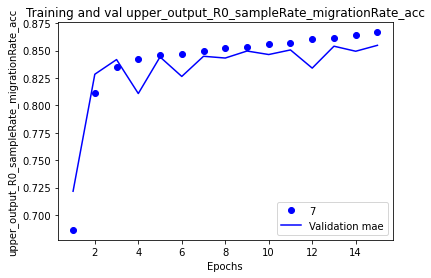

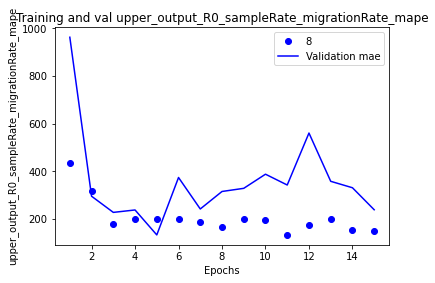

In [67]:
# instantiate MODEL
# set inner quantile
qq = 0.05

def pinball_loss_lower(y_true, y_pred):
    return pinball_loss(y_true, y_pred, tau = (1-qq)/2)

def pinball_loss_upper(y_true, y_pred):
    return pinball_loss(y_true, y_pred, tau = 1 - (1-qq)/2)

mymodel_05q = create_model()
mymodel_05q.compile(optimizer = 'adam', 
                loss = [pinball_loss_lower, pinball_loss_upper], 
                metrics = ['mae', 'acc', 'mape'])

history = mymodel_05q.fit([train_treeLocation_tensor, train_prior_tensor], 
                      [norm_train_labels, norm_train_labels],
                    epochs = 15, batch_size = 128, 
                    validation_data = ([validation_treeLocation_tensor, validation_prior_tensor], 
                                       [norm_validation_labels, norm_validation_labels]))



# make history plots
cn.make_history_plot(history)

# store model
mymodel_05q.save("trained_quantile_CNN/cqr05_train_extant_R0_sampleRate_migrationRate.hdf5")
